# this version is not correct, cause I'm trying to have the agent learn decks differently! 

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class CardEnvironment:
    """
    A partially observed environment:
      - The agent only sees (deck_type, card1).
      - Internally, the environment draws (card1, card2).
      - After the agent decides action, the environment reveals card2
        *internally* to compute the reward.
    """
    def __init__(self, deck1, deck2, deck_type):
        self.original_deck1 = deck1
        self.original_deck2 = deck2
        self.deck_type = deck_type  # uniform, high, low,  mixed
        self.reset()

    def reset(self):
        self.deck1 = self.original_deck1.copy()
        self.deck2 = self.original_deck2.copy()
        random.shuffle(self.deck1)
        random.shuffle(self.deck2)
        self.current_card1 = None
        self.current_card2 = None

    def get_observation(self):
        """
        Draw one pair of cards (card1, card2).
        Return: 
          state_obs = (deck_type, card1)
          done      = True if out of cards
        """
        if not self.deck1 or not self.deck2:
            return None, True

        self.current_card1 = self.deck1.pop()
        self.current_card2 = self.deck2.pop()

        # show only deck_type and card1
        state_obs = (self.deck_type, self.current_card1)
        return state_obs, False

    def step(self, action):
        """
        action = 0 => guess card1 < card2
        action = 1 => guess card1 > card2
        Returns: 
          reward : float
          done   : True if out of cards after this step
        """
        if self.current_card1 is None or self.current_card2 is None:
            return 0.0, True  # safety check

        correct = ((action == 0 and self.current_card1 < self.current_card2) or
                   (action == 1 and self.current_card1 > self.current_card2))
        reward = 0.5 if correct else -0.5

        # we can't reuse the same pair so I clear them
        self.current_card1 = None
        self.current_card2 = None

        # done if out of cards 
        done = (not self.deck1 or not self.deck2)
        return reward, done



In [3]:

class RLAgent:
    """
    The agent stores Q-values in a dictionary:
      Q[(deck_type, card1)][action] = Q-value
    where action in {0 (guess "<"), 1 (guess ">")}.
    """
    def __init__(self, alpha=0.01, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.98):
        self.alpha = alpha
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.Q = {}  # dict: key=(deck_type, card1), value=[Q(a=0), Q(a=1)]

    def get_q_values(self, state):
        """
        state = (deck_type, card1)
        Return the Q-value list [Q_for_action0, Q_for_action1].
        Initialize to [0,0] if unseen.
        """
        if state not in self.Q:
            self.Q[state] = [0.0, 0.0]
        return self.Q[state]

    def choose_action(self, state):
        """
        Epsilon-greedy action selection:
          0 -> guess card1 < card2
          1 -> guess card1 > card2
        """
        q_values = self.get_q_values(state)
        if random.random() < self.epsilon:
            return random.choice([0, 1])
        else:
            return np.argmax(q_values)

    def update_q_values(self, state, action, reward):
        """
        One-step update for contextual bandit:
        Q(s,a) += alpha * [reward - Q(s,a)]
        """
        q_values = self.get_q_values(state)
        old_val = q_values[action]
        q_values[action] = old_val + self.alpha * (reward - old_val)

    def decay_epsilon(self):
        #Decay epsilon each episode.
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


In [4]:
def moving_average(data, window=50):
    # better visualization
    return np.convolve(data, np.ones(window)/window, mode='valid')

In [5]:
def train_agent_on_env(agent, env, num_episodes=500):

    # Train agent for num_episodes on the given environment. Returns a list of total rewards per episode.
    rewards_per_episode = []

    for _ in range(num_episodes):
        env.reset()
        total_reward = 10

        while True:
            # Observe
            state, done = env.get_observation()
            if done:
                break

            # Pick action
            action = agent.choose_action(state)

            # Step environment
            reward, done = env.step(action)

            # Update
            agent.update_q_values(state, action, reward)
            total_reward += reward

            if done:
                break

        # End of episode
        agent.decay_epsilon()
        rewards_per_episode.append(total_reward)

    return rewards_per_episode



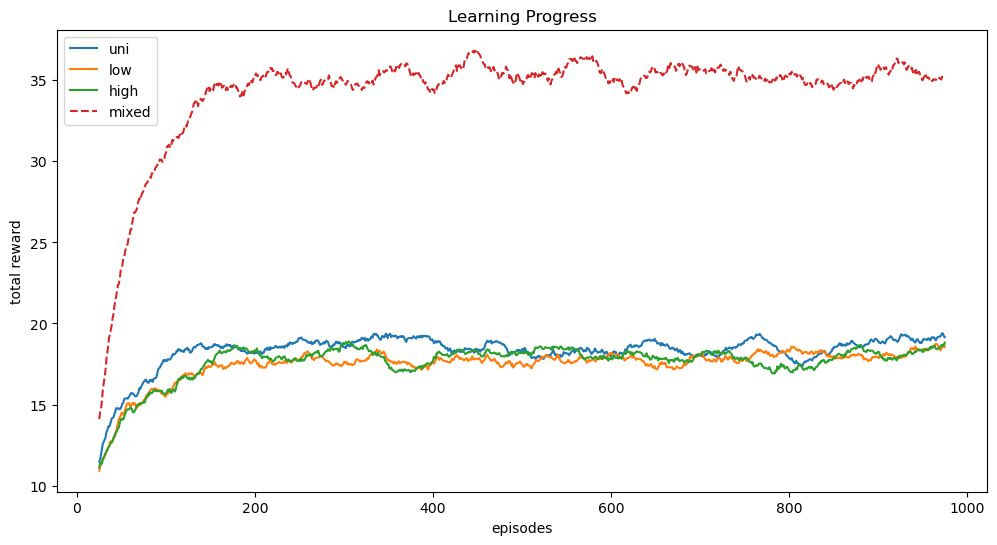

In [6]:

if __name__ == "__main__":
    # Example decks
    uniform_deck1 = [1,1,1,1,1, 2,2,2,2,2, 3,3,3,3,3,
                     4,4,4,4,4, 5,5,5,5,5, 6,6,6,6,6,
                     7,7,7,7,7, 8,8,8,8,8, 9,9,9,9,9]
    uniform_deck2 = uniform_deck1.copy()

    low_deck1 = [1,1,1,1,1,1,1,1,1,
                 2,2,2,2,2,2,2,2,
                 3,3,3,3,3,3,3,
                 4,4,4,4,4,4,
                 5,5,5,5,5,
                 6,6,6,6,
                 7,7,7,
                 8,8,
                 9]
    low_deck2 = low_deck1.copy()

    high_deck1 = [9,9,9,9,9,9,9,9,9,
                  8,8,8,8,8,8,8,8,
                  7,7,7,7,7,7,7,
                  6,6,6,6,6,6,
                  5,5,5,5,5,
                  4,4,4,4,
                  3,3,3,
                  2,2,
                  1]
    high_deck2 = high_deck1.copy()

    # Mixed deck
    mixed_deck1 = uniform_deck1 + low_deck1 + high_deck1
    mixed_deck2 = uniform_deck2 + low_deck2 + high_deck2

    # Create Environments
    uniform_env  = CardEnvironment(uniform_deck1, uniform_deck2, 'black')
    low_env = CardEnvironment(low_deck1,     low_deck2,     'orange')
    high_env  = CardEnvironment(high_deck1,    high_deck2,    'green')
    mixed_env  = CardEnvironment(mixed_deck1,   mixed_deck2,   'mixed')

    # We train separate agents, each with possibly different hyperparams
    uniform_agent  = RLAgent(alpha=0.01, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.98)
    low_agent = RLAgent(alpha=0.01, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.98)
    high_agent  = RLAgent(alpha=0.01, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.98)
    mixed_agent  = RLAgent(alpha=0.01, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.98)
    

   
    num_episode = 1000

    # train each agent on its environment
    uniform_rewards  = train_agent_on_env(uniform_agent,  uniform_env,  num_episodes=num_episode)
    low_rewards = train_agent_on_env(low_agent, low_env, num_episodes=num_episode)
    high_rewards  = train_agent_on_env(high_agent,  high_env,  num_episodes=num_episode)
    mixed_rewards  = train_agent_on_env(mixed_agent,  mixed_env,  num_episodes=num_episode)


    
    win_size = 50
    uniform_ma  = moving_average(uniform_rewards,  window=win_size)
    low_ma = moving_average(low_rewards, window=win_size)
    high_ma  = moving_average(high_rewards,  window=win_size)
    mixed_ma  = moving_average(mixed_rewards,  window=win_size)


    plt.figure(figsize=(12, 6))
    
    xvals_uniform  = np.arange(len(uniform_ma))  + (win_size//2)
    xvals_low = np.arange(len(low_ma)) + (win_size//2)
    xvals_high  = np.arange(len(high_ma))  + (win_size//2)
    xvals_mixed  = np.arange(len(mixed_ma))  + (win_size//2)
    
    plt.plot(xvals_uniform,  uniform_ma,  label="uni")
    plt.plot(xvals_low, low_ma, label="low")
    plt.plot(xvals_high,  high_ma,  label="high")
    plt.plot(xvals_mixed,  mixed_ma,  label="mixed", linestyle='--')

    plt.xlabel("episodes")
    plt.ylabel("total reward")
    plt.title(f"Learning Progress")
    plt.legend()
    plt.show()


In [7]:
# compare e greedy with easy policy
uniform_rewards

[9.5,
 3.5,
 4.5,
 6.5,
 8.5,
 7.5,
 8.5,
 3.5,
 12.5,
 8.5,
 11.5,
 7.5,
 4.5,
 4.5,
 12.5,
 10.5,
 3.5,
 8.5,
 5.5,
 15.5,
 11.5,
 14.5,
 18.5,
 12.5,
 14.5,
 8.5,
 10.5,
 8.5,
 13.5,
 14.5,
 15.5,
 16.5,
 9.5,
 15.5,
 12.5,
 12.5,
 11.5,
 16.5,
 18.5,
 24.5,
 12.5,
 17.5,
 9.5,
 12.5,
 8.5,
 16.5,
 11.5,
 14.5,
 13.5,
 20.5,
 16.5,
 20.5,
 20.5,
 22.5,
 13.5,
 14.5,
 14.5,
 20.5,
 17.5,
 20.5,
 10.5,
 13.5,
 14.5,
 14.5,
 14.5,
 12.5,
 13.5,
 16.5,
 15.5,
 14.5,
 11.5,
 14.5,
 15.5,
 16.5,
 20.5,
 16.5,
 13.5,
 19.5,
 15.5,
 14.5,
 15.5,
 15.5,
 14.5,
 19.5,
 17.5,
 16.5,
 9.5,
 16.5,
 15.5,
 19.5,
 12.5,
 17.5,
 15.5,
 18.5,
 20.5,
 14.5,
 18.5,
 19.5,
 19.5,
 25.5,
 17.5,
 25.5,
 18.5,
 16.5,
 11.5,
 16.5,
 21.5,
 17.5,
 20.5,
 14.5,
 19.5,
 15.5,
 14.5,
 17.5,
 23.5,
 27.5,
 17.5,
 18.5,
 21.5,
 19.5,
 15.5,
 22.5,
 12.5,
 20.5,
 16.5,
 17.5,
 18.5,
 18.5,
 14.5,
 17.5,
 19.5,
 22.5,
 18.5,
 17.5,
 19.5,
 19.5,
 16.5,
 14.5,
 22.5,
 16.5,
 13.5,
 12.5,
 16.5,
 18.5,
 17.5,
 22.5,